In [1]:
#pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2,os

In [4]:
#accessing dataset for training
datapath="C:\\Users\\parth\\Downloads\\Face-Mask-Detection-master\\Face-Mask-Detection-master\\dataset"
categories=os.listdir(datapath)
print(categories)

#Labeling dataset for 1 for 'with mark' and o for 'without mask'
label_dict=dict(zip(categories,[1,0]))
print(label_dict)

['without_mask', 'with_mask']
{'without_mask': 1, 'with_mask': 0}


In [5]:
#List for image data
image_list=[]
image_type=[]
from skimage import io

#Accessing each image
for category in  categories:
  folder_path=os.path.join(datapath,category)
  
  #Getting list of images ina category
  img_names=os.listdir(folder_path)
  
  #Getting image to bits in gray form
  for image in img_names:
    image_path=os.path.join(folder_path,image)
    #img=cv2.imread(image_path)
    img = io.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
    resized=cv2.resize(gray,(150,150))
    image_list.append(resized)
    image_type.append(label_dict[category])
  #  break

In [6]:
#Normanliztion of numbers
import numpy as np
from keras.utils import np_utils
image_list=np.array(image_list)/255
image_list=np.reshape(image_list,(image_list.shape[0],150,150,1))
image_type=np_utils.to_categorical(image_type)

In [7]:
#Creating deep learning model
from tensorflow import keras

model=keras.Sequential([
    keras.layers.Conv2D(10,3,padding='same',activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(5,3,padding='same',activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(20,activation='relu'),
    keras.layers.Dense(2,activation='softmax')
])
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
           )

In [8]:
#Split data into train and test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_list,image_type,test_size=0.2,random_state=1) 

In [9]:
#Training a model
rom keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(x_train,y_train,epochs=5,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/5
77/77 [==============================] - 17s 214ms/step - loss: 0.5763 - accuracy: 0.6986 - val_loss: 0.4617 - val_accuracy: 0.7964
Epoch 2/5
77/77 [==============================] - 15s 198ms/step - loss: 0.3723 - accuracy: 0.8544 - val_loss: 0.3710 - val_accuracy: 0.8502
Epoch 3/5
77/77 [==============================] - 16s 202ms/step - loss: 0.2932 - accuracy: 0.8862 - val_loss: 0.3441 - val_accuracy: 0.8534
Epoch 4/5
77/77 [==============================] - 16s 212ms/step - loss: 0.2561 - accuracy: 0.8940 - val_loss: 0.3242 - val_accuracy: 0.8583
Epoch 5/5
77/77 [==============================] - 17s 216ms/step - loss: 0.2063 - accuracy: 0.9168 - val_loss: 0.2844 - val_accuracy: 0.8876


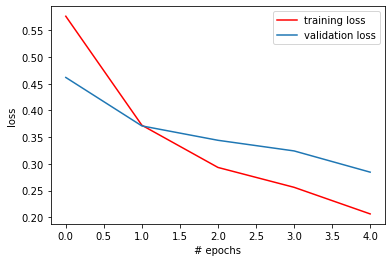

In [10]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

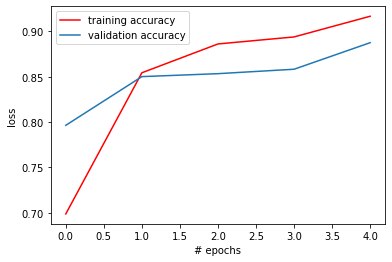

In [11]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
#Accessing webcam and face detection module
import cv2
from keras.models import load_model
import numpy as np
model = load_model('model-003.model')

#Detecting masks
face_clsfr=cv2.CascadeClassifier('C:\\Users\\parth\\anaconda3\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
source=cv2.VideoCapture(0)
labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [15]:
#Opening a webcam and accessing the images
while(True):
  ret,img=source.read()
  face_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  faces=face_clsfr.detectMultiScale(face_img,1.3,5)

  for x,y,w,h in faces:
        face_img=face_img[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(150,150))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,150,150,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
  cv2.imshow('LIVE',img)
  key=cv2.waitKey(1)
    
  if(key==27):
    break
        
cv2.destroyAllWindows()
source.release()